# SAMD9L
[ataxia-pancytopenia syndrome (ATXPC)](https://omim.org/entry/159550) is caused by heterozygous mutation in the SAMD9L gene. 

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.2


# SAMD9L
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SAMD9L.

In [2]:
gene_symbol = 'SAMD9L'
mane_tx_id = 'NM_152703.5'
mane_protein_id = 'NP_689916.2' # sterile alpha motif domain-containing protein 9-like

### Phenopackets
We loaded a cohort of 22 phenopackets representing published descriptions of individuals with pathogenic variants in ASPM diagnosed with MCPH5.
TODO UPDATE

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.23'
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 31/31 [00:12<00:00,  2.51 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
19,Thrombocytopenia
16,Neutropenia
16,Unsteady gait
12,Pancytopenia
12,Myelodysplasia
10,Anemia
10,Cerebellar atrophy
9,Hyperreflexia
9,Ataxia
9,Gaze-evoked horizontal nystagmus


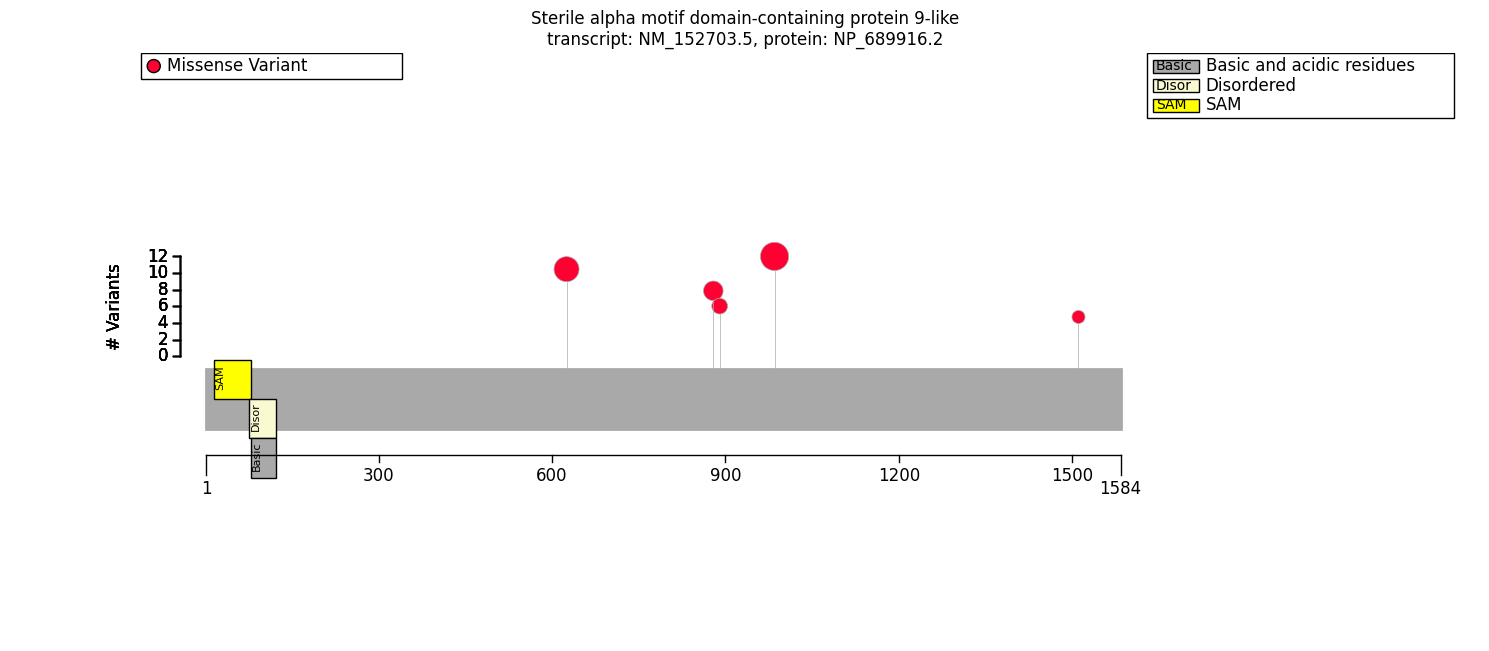

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

samd9l_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
samd9l_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model.genome import Region
from gpsea.analysis.clf import  monoallelic_classifier
from gpsea.analysis.predicate import protein_region
from gpsea.view import MtcStatsViewer


n_term = protein_region(region=Region(0, 950), tx_id=mane_tx_id)
nterm_clf = monoallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N Term",
    b_label="other")
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,5
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,52
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,75


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                 N Term          other          \
                                              Count Percent  Count Percent   
Neutropenia [HP:0001875]                       6/15     40%  10/12     83%   
Thrombocytopenia [HP:0001873]                  8/17     47%  11/13     85%   
Pancytopenia [HP:0001876]                      5/14     36%    7/9     78%   
Ankle clonus [HP:0011448]                      4/14     29%    2/2    100%   
Dysarthria [HP:0001260]                        7/15     47%    0/2      0%   
Anemia [HP:0001903]                            5/14     36%   5/11     45%   
Abnormal platelet count [HP:0011873]            8/8    100%  11/11    100%   
Abnormal neutrophil count [HP:0011991]          6/6    100%  10/10    100%   
Abnormal granulocyte morphology [HP:0001911]    6/6    100%  10/10    100%   
Hyperreflexia [HP:0001347]                    13/13    100%    2/2    100%   
Abnormal reflex [HP:0031826]                  13/13    100%    2/2    100%   
Unsteady gait [HP:0002317]                    12/14     86%    4/4    100%   
Gait disturbance [HP:0001288]                 12/12    100%    4/4    100%   
Ataxia [HP:0001251]                           13/13    100%    2/2    100%   
Nystagmus [HP:0000639]                        14/14    100%    4/4    100%   

Allele group                                                               
                                             Corrected p values  p values  
Neutropenia [HP:0001875]                               0.430927  0.047328  
Thrombocytopenia [HP:0001873]                          0.430927  0.057457  
Pancytopenia [HP:0001876]                              0.446897  0.089379  
Ankle clonus [HP:0011448]                              0.468750  0.125000  
Dysarthria [HP:0001260]                                1.000000  0.485294  
Anemia [HP:0001903]                                    1.000000  0.696830  
Abnormal platelet count [HP:0011873]                   1.000000  1.000000  
Abnormal neutrophil count [HP:0011991]                 1.000000  1.000000  
Abnormal granulocyte morphology [HP:0001911]           1.000000  1.000000  
Hyperreflexia [HP:0001347]                             1.000000  1.000000  
Abnormal reflex [HP:0031826]                           1.000000  1.000000  
Unsteady gait [HP:0002317]                             1.000000  1.000000  
Gait disturbance [HP:0001288]                          1.000000  1.000000  
Ataxia [HP:0001251]                                    1.000000  1.000000  
Nystagmus [HP:0000639]                                 1.000000  1.000000

The following is driven by multiple observations of Arg986Cys in a family with ataxia-pancytopenia syndrome (PMID:28202457) as
well as  multiple observations of Ser626Leu spinocerebellar ataxia-49 (PMID:35310830). Our entire cohort of 31 individuals is
relatively small to attain high statistical power.

In [9]:
from gpsea.analysis.predicate import variant_key

arg986cys = variant_key("7_93133016_93133016_G_A") # c.2956C>T p.Arg986Cys	
ser626leu = variant_key("7_93134095_93134095_G_A") # c.1877C>T p.Ser626Leu	(9 individuals)

arg986cys_clf = monoallelic_classifier(
    a_predicate=arg986cys,
    b_predicate=ser626leu,
    a_label="Arg986Cys",
    b_label="Ser626Leu")
arg986cys_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=arg986cys_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=arg986cys_result)

Allele group                  Arg986Cys         Ser626Leu          \
                                  Count Percent     Count Percent   
Thrombocytopenia [HP:0001873]       7/9     78%       0/9      0%   
Neutropenia [HP:0001875]            7/9     78%       0/9      0%   
Pancytopenia [HP:0001876]           4/6     67%       0/9      0%   
Unsteady gait [HP:0002317]          4/4    100%       9/9    100%   
Gait disturbance [HP:0001288]       4/4    100%       9/9    100%   
Nystagmus [HP:0000639]              4/4    100%       9/9    100%   

Allele group                                                
                              Corrected p values  p values  
Thrombocytopenia [HP:0001873]           0.006787  0.002262  
Neutropenia [HP:0001875]                0.006787  0.002262  
Pancytopenia [HP:0001876]               0.021978  0.010989  
Unsteady gait [HP:0002317]              1.000000  1.000000  
Gait disturbance [HP:0001288]           1.000000  1.000000  
Nystagmus [HP:0000639]                  1.000000  1.000000

# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=arg986cys_result,
    ),
)

caption = """A recent summary of SAMD9L variants stated there was no evidence of phenotype–genotype correlation \\cite{PMID_38594844}.
"""

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [13]:
summarizer.process_latex(report=report, protein_fig=samd9l_fig)

Figure saved to ../../supplement/img/SAMD9L_protein_diagram-draft.pdf
Output to ../../supplement/tex/SAMD9L_summary_draft.tex
